## Get the Dependencies

In [2]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


In [25]:
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

import data_setup
import engine
from helper_functions import download_data, set_seeds, plot_loss_curves, pred_and_plot_image

In [4]:
#device = "cuda" if torch.cuda.is_available() else "cpu" # My gpu driver acting up, to lazy to fix atm
device = "cpu"
device

'cpu'

## Get the Data

In [5]:
# Get dummy data set from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                            destination="pizza_steak_sushi")

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
# From hyper-parameter table details (table 3 in paper) 
IMG_SIZE = 224

# Image resizing
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Data Loader Transforms: {manual_transforms}")

Data Loader Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
# From hyper-parameter table details (table 3 in paper)
BATCH_SIZE = 32 #my 3080 says help # Paper says 4096 but lol ig i need grant money

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x74136c99c2e0>,
 ['pizza', 'steak', 'sushi'])

(-0.5, 223.5, 223.5, -0.5)

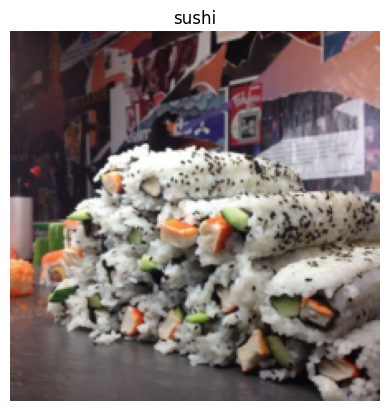

In [9]:
# View an image
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

## ViT Replication

### Image Patching Experimentation

#### Embedding Module

In [10]:
# Pytorch module

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [11]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


#### Multi Head Self Attention Block

In [12]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

#### MLP Block

In [13]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, mlp_size:int=3072, dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        return self.mlp(x)

#### Transformer Encoder Block

In [14]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12, mlp_size:int=3072, mlp_dropout:float=0.1, attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x
        return self.mlp_block(x) + x

In [15]:
# or just
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

#### Full ViT

In [16]:
class ViT(nn.Module):
    def __init__(self, 
                 img_size=224, 
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size"
        
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x


In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit_out = vit(random_image_tensor)

print(f"Shape of vit input: {random_image_tensor.shape}")
print(f"Shape of vit output: {vit_out.shape}")
print(f"Input Val: {random_image_tensor}")
print(f"Output Val: {vit_out}")

Shape of vit input: torch.Size([1, 3, 224, 224])
Shape of vit output: torch.Size([1, 3])
Input Val: tensor([[[[ 1.9269,  1.4873,  0.9007,  ..., -0.5003,  1.0350,  1.6896],
          [-0.0045,  1.6668,  0.1539,  ...,  1.1895,  0.7607, -0.7463],
          [-1.3839,  0.4869, -1.0020,  ...,  0.8395,  0.0585, -1.6682],
          ...,
          [-0.9935, -0.4282, -0.1569,  ..., -1.4605,  0.4858,  1.4561],
          [-0.2184, -0.4147, -0.3406,  ..., -0.7876,  1.0787, -1.2681],
          [ 1.4045,  0.2526, -0.5242,  ..., -0.9805,  0.2299, -0.4141]],

         [[ 1.4765,  0.2040, -0.3549,  ...,  0.6679,  0.4566, -0.3406],
          [-0.7102, -1.6981,  1.3142,  ..., -1.0838, -1.8464, -0.8120],
          [-1.5338,  1.5187, -1.1411,  ...,  1.8598, -1.7908,  0.6991],
          ...,
          [-0.5990, -0.2488, -0.2242,  ..., -0.6357,  0.8167, -1.1636],
          [ 0.3473, -1.8995,  1.2217,  ..., -0.8756,  0.9081, -0.7743],
          [ 0.6946,  0.0187,  1.3379,  ..., -0.3467, -0.8503, -0.3895]],

  

### Training

##### Using Supervised As Don't have enough data or compute to pre-train

In [ ]:
# Using Hyper Parameters from table 3 in ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

vit = ViT(num_classes=len(class_names))

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)




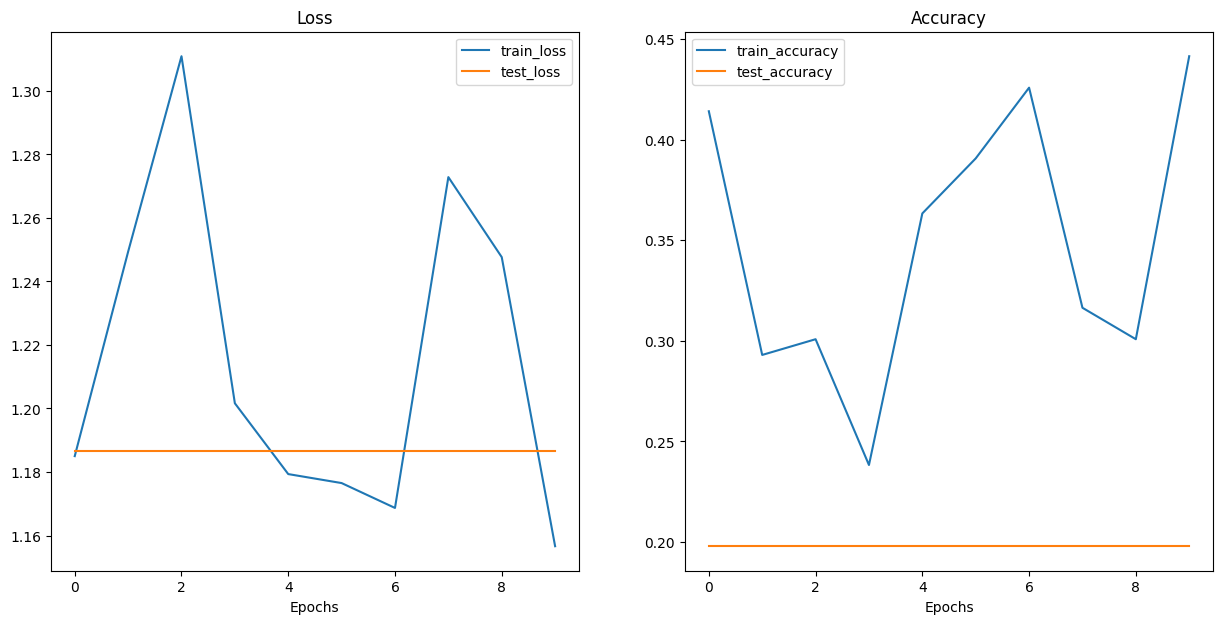

In [19]:
plot_loss_curves(results)

save_path = "models/supervised_no_pretraining/"
torch.save(vit.state_dict(), save_path + "model")
torch.save(optimizer.state_dict(), save_path + "optim")

#### Training with pre-trained model from PyTorch

In [20]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze model
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Add new last layer
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [21]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [22]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [23]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


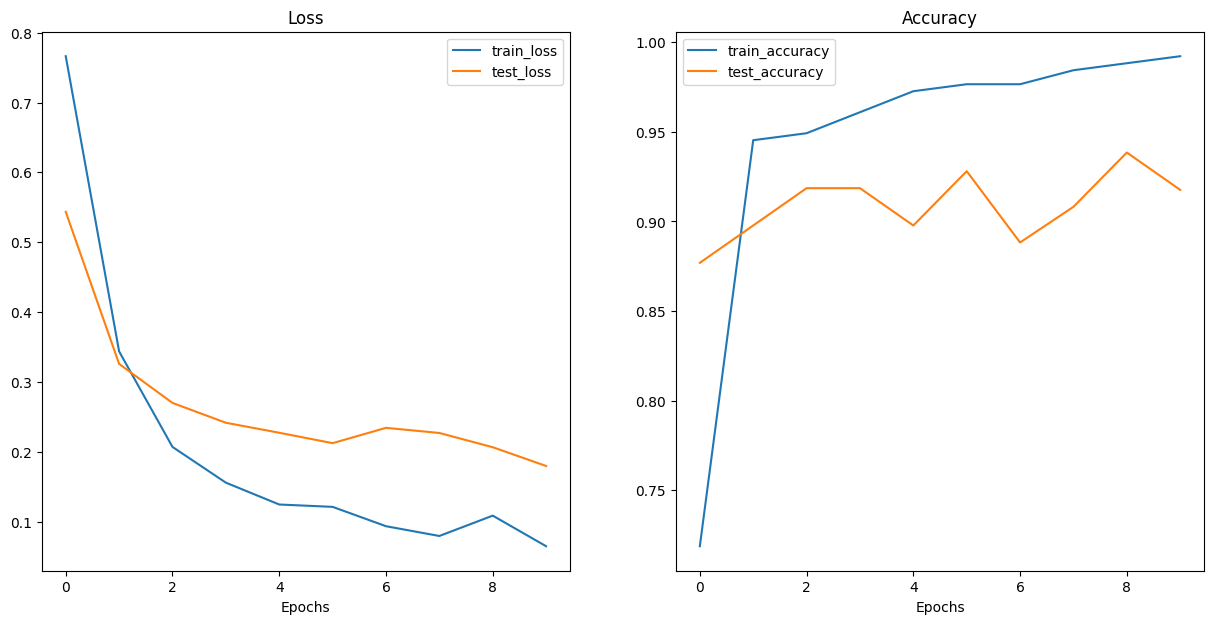

In [24]:
plot_loss_curves(pretrained_vit_results)

save_path = "models/supervised_pretrained/"
torch.save(pretrained_vit.state_dict(), save_path + "model")
torch.save(optimizer.state_dict(), save_path + "optim")

### Inference Examples

In [40]:
custom_image_paths = {"pizza": image_path/"test"/"pizza"/"194643.jpg", 
                      "steak": image_path/"test"/"steak"/"296375.jpg", 
                      "sushi": image_path/"test"/"sushi"/"46797.jpg"}

2024-09-30 16:20:54,555 matplotlib.image [WARNING] - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


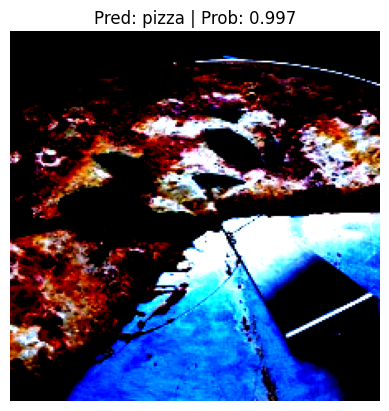

In [41]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_paths["pizza"],
                    class_names=class_names,
                    transform=pretrained_vit_transforms,
                    device=device)

2024-09-30 16:20:55,535 matplotlib.image [WARNING] - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


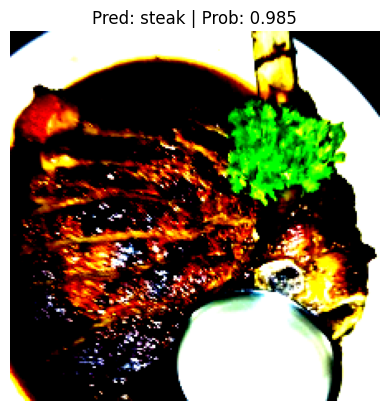

In [42]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_paths["steak"],
                    class_names=class_names,
                    transform=pretrained_vit_transforms,
                    device=device)

2024-09-30 16:21:09,899 matplotlib.image [WARNING] - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


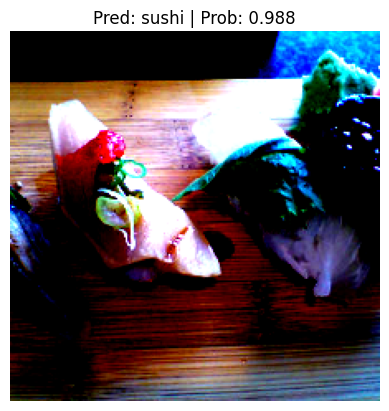

In [43]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_paths["sushi"],
                    class_names=class_names,
                    transform=pretrained_vit_transforms,
                    device=device)